# Exemplo de previsão de séries temporais com ARIMA

**Resumo:**

* Neste notebook, estudaremos as [ocorrências de acidentes de trânsito em rodovias brasileiras registradas pela Polícia Rodoviária Federal](https://portal.prf.gov.br/dados-abertos-acidentes) para entendermos séries temporais na prática.
 
---

**Autores:**

* [Carlos Maurício Seródio Figueiredo](https://www.linkedin.com/in/cmsfigueiredo/): É professor adjunto da Escola Superior de Tecnologia da Universidade do Estado do Amazonas (EST/UEA) e professor colaborador do Programa de Pós-graduação em Informática da Universidade Federal do Amazonas. Também é co-fundador do Laboratório de Sistemas Inteligentes da UEA e pesquisador no Samsung Ocean Manaus.
* [Alice Adativa Ferreira Menezes](https://www.linkedin.com/in/alice-adativa/): É doutoranda na Universidade Federal do Amazonas (UFAM) e  pesquisadora no Samsung Ocean Manaus.

---

**Para saber mais:**

* Palestras e cursos do [Samsung Ocean](http://www.oceanbrasil.com/).
* Robert H. Shumway. Time series analysis and its applications. Springer, 2000.
* Aileen Nielsen. Practical Time Series Analysis. O’Reilly, 2019.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

In [2]:
sns.set(font_scale=1.4)
sns.set_style({'font.family': 'serif',
               'fontname': 'Times New Roman'})

## 1) Carregando e tratando os dados

* A base de dados para o nosso estudo foi obtida por meio da iniciativa de dados abertos da [Polícia Rodoviária Federal](https://portal.prf.gov.br/dados-abertos-acidentes). 


* Você tem a opção de baixar estes dados na fonte e fazer o upload no Kaggle, porém já temos essa [base de dados disponível publicamente](https://www.kaggle.com/mcamera/brazil-highway-traffic-accidents) nesta plataforma.


* Nas as próximas seções, utilizaremos dados dos anos de 2017, 2018 e 2019 para o nosso estudo.

In [3]:
datatran_2017_df = pd.read_csv('../input/brazil-highway-traffic-accidents/por_ocorrencias/datatran2017.csv', 
                               sep = ';',
                               encoding = 'latin-1')

datatran_2018_df = pd.read_csv('../input/brazil-highway-traffic-accidents/por_ocorrencias/datatran2018.csv', 
                               sep = ';',
                               encoding = 'latin-1')

datatran_2019_df = pd.read_csv('../input/brazil-highway-traffic-accidents/por_ocorrencias/datatran2019.csv', 
                               sep = ';',
                               encoding = 'latin-1')

In [4]:
datatran_2017_df.head()

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,8,2017-01-01,domingo,00:00:00,PR,376.0,112,PARANAVAI,Fenômenos da Natureza,Queda de ocupante de veículo,...,1,0,0,1,1,"-23,09880731","-52,38789369",SR-PR,DEL7/7,UOP05/PR
1,9,2017-01-01,domingo,00:01:00,SC,101.0,234,PALHOCA,Falta de Atenção à Condução,Colisão com objeto estático,...,0,1,0,0,1,"-27,8101","-48,6357",SR-SC,DEL8/1,UOP02/SC
2,11,2017-01-01,domingo,00:00:00,PR,153.0,"56,9",SANTO ANTONIO DA PLATINA,Animais na Pista,Capotamento,...,0,0,0,2,1,"-23,36951985","309,93513107",SR-PR,DEL7/7,UOP07/PR
3,12,2017-01-01,domingo,00:00:00,GO,153.0,435,ANAPOLIS,Avarias e/ou desgaste excessivo no pneu,Tombamento,...,1,0,0,1,1,"-16,27473677","-48,96908998",SR-GO,DEL1/2,UOP01/GO
4,13,2017-01-01,domingo,00:00:00,SC,280.0,"77,3",CORUPA,Ingestão de Álcool,Saída de leito carroçável,...,0,0,0,1,1,"-26,44675249","-49,20166969",SR-SC,DEL8/6,UOP03/SC


In [5]:
datatran_2018_df.head()

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,99973.0,2018-01-01,segunda-feira,00:20:00,RJ,116.0,"303,5",RESENDE,Condutor Dormindo,Saída de leito carroçável,...,4,1,0,4,1,"-22,46937","-44,44705",SR-RJ,DEL5/7,UOP03/RJ
1,99976.0,2018-01-01,segunda-feira,00:40:00,SC,282.0,"0,4",FLORIANOPOLIS,Não guardar distância de segurança,Colisão traseira,...,2,1,0,2,2,"-27,59971687","-48,57565694",SR-SC,DEL8/1,UOP01/SC
2,99977.0,2018-01-01,segunda-feira,00:30:00,RJ,493.0,1,ITABORAI,Ultrapassagem Indevida,Colisão frontal,...,0,3,1,1,3,"-22,763901","-42,927532",SR-RJ,DEL5/4,UOP02/RJ
3,99981.0,2018-01-01,segunda-feira,01:15:00,RS,386.0,134,SARANDI,Ingestão de Álcool,Colisão transversal,...,0,2,0,0,2,"-27,953636","-52,916374",SR-RS,DEL9/14,UOP01/RS
4,99982.0,2018-01-01,segunda-feira,00:20:00,RS,293.0,"151,7",CANDIOTA,Falta de Atenção à Condução,Saída de leito carroçável,...,1,0,0,1,1,"-31,395214","-53,78391174",SR-RS,DEL9/11,UOP03/RS


In [6]:
datatran_2019_df.head()

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,182210.0,2019-01-01,terça-feira,01:30:00,SP,116.0,218,GUARULHOS,Falta de Atenção à Condução,Colisão com objeto estático,...,0,0,0,4,1,"-23,46052014","-46,48772478",SR-SP,DEL6/1,UOP01/SP
1,182211.0,2019-01-01,terça-feira,01:30:00,PR,373.0,"177,3",PONTA GROSSA,Falta de Atenção à Condução,Colisão traseira,...,0,0,0,1,1,"-25,05533957","-50,22776753",SR-PR,DEL7/3,UOP01/PR
2,182212.0,2019-01-01,terça-feira,00:45:00,SC,101.0,16,GARUVA,Animais na Pista,Colisão com objeto estático,...,0,0,0,1,1,"-26,1216","-48,8826",SR-SC,DEL8/3,UOP01/SC
3,182214.0,2019-01-01,terça-feira,00:00:00,CE,20.0,"429,5",FORTALEZA,Ingestão de Substâncias Psicoativas,Colisão com objeto estático,...,1,0,0,1,1,"-3,76999","-38,670063",SR-CE,DEL16/1,UOP02/CE
4,182215.0,2019-01-01,terça-feira,01:00:00,MG,381.0,327,NOVA ERA,Falta de Atenção à Condução,Colisão transversal,...,1,1,0,1,2,"-19,7609","-43,0306",SR-MG,DEL4/3,UOP01/MG


In [7]:
datatran_df = pd.concat([datatran_2017_df, datatran_2018_df, datatran_2019_df])

In [8]:
datatran_df

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,8.0,2017-01-01,domingo,00:00:00,PR,376.0,112,PARANAVAI,Fenômenos da Natureza,Queda de ocupante de veículo,...,1,0,0,1,1,"-23,09880731","-52,38789369",SR-PR,DEL7/7,UOP05/PR
1,9.0,2017-01-01,domingo,00:01:00,SC,101.0,234,PALHOCA,Falta de Atenção à Condução,Colisão com objeto estático,...,0,1,0,0,1,"-27,8101","-48,6357",SR-SC,DEL8/1,UOP02/SC
2,11.0,2017-01-01,domingo,00:00:00,PR,153.0,"56,9",SANTO ANTONIO DA PLATINA,Animais na Pista,Capotamento,...,0,0,0,2,1,"-23,36951985","309,93513107",SR-PR,DEL7/7,UOP07/PR
3,12.0,2017-01-01,domingo,00:00:00,GO,153.0,435,ANAPOLIS,Avarias e/ou desgaste excessivo no pneu,Tombamento,...,1,0,0,1,1,"-16,27473677","-48,96908998",SR-GO,DEL1/2,UOP01/GO
4,13.0,2017-01-01,domingo,00:00:00,SC,280.0,"77,3",CORUPA,Ingestão de Álcool,Saída de leito carroçável,...,0,0,0,1,1,"-26,44675249","-49,20166969",SR-SC,DEL8/6,UOP03/SC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67441,266255.0,2019-10-07,segunda-feira,09:10:00,ES,101.0,"270,5",SERRA,Falta de Atenção à Condução,Tombamento,...,1,1,0,1,2,"-20,23107","-40,27387",SR-ES,DEL12/2,UOP01/ES
67442,266406.0,2019-11-25,segunda-feira,07:20:00,PR,116.0,125,FAZENDA RIO GRANDE,Falta de Atenção à Condução,Colisão lateral,...,0,1,1,1,2,"-25,59505","-49,31631",SR-PR,DEL7/1,UOP03/PR
67443,266434.0,2019-06-03,segunda-feira,19:00:00,CE,222.0,"1,4",CAUCAIA,Não guardar distância de segurança,Colisão traseira,...,1,1,0,1,2,"-3,736507","-38,65337",SR-CE,DEL16/1,UOP01/CE
67444,266573.0,2019-07-13,sábado,19:35:00,PR,373.0,425,CANDOI,Defeito Mecânico no Veículo,Saída de leito carroçável,...,1,0,0,1,1,"-25,7118","-52,18374",SR-PR,DEL7/3,UOP02/PR


---
* Antes de trabalhar com séries temporais, no geral, você precisa converter e transformar os dados caso seja necessário. 


* Normalmente estes dados estão em diferentes formatos dentro de um DataFrame.


* Neste exemplo, vamos analisar especificamente informações a respeito da **data em que o acidente ocorreu**.
---

In [9]:
datatran_df.dtypes

id                        float64
data_inversa               object
dia_semana                 object
horario                    object
uf                         object
br                        float64
km                         object
municipio                  object
causa_acidente             object
tipo_acidente              object
classificacao_acidente     object
fase_dia                   object
sentido_via                object
condicao_metereologica     object
tipo_pista                 object
tracado_via                object
uso_solo                   object
pessoas                     int64
mortos                      int64
feridos_leves               int64
feridos_graves              int64
ilesos                      int64
ignorados                   int64
feridos                     int64
veiculos                    int64
latitude                   object
longitude                  object
regional                   object
delegacia                  object
uop           

In [10]:
datatran_df['data_inversa'] = pd.to_datetime(datatran_df['data_inversa'], 
                                             yearfirst = True,
                                             format = '%Y-%m-%d')

In [11]:
datatran_df.sort_values(by = 'data_inversa', inplace = True)

In [12]:
datatran_df

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,8.0,2017-01-01,domingo,00:00:00,PR,376.0,112,PARANAVAI,Fenômenos da Natureza,Queda de ocupante de veículo,...,1,0,0,1,1,"-23,09880731","-52,38789369",SR-PR,DEL7/7,UOP05/PR
213,272.0,2017-01-01,domingo,19:20:00,PE,232.0,"408,9",SERRA TALHADA,Desobediência às normas de trânsito pelo condutor,Colisão transversal,...,2,0,0,2,2,"-8,0578381","-34,8828969",SR-PE,DEL11/4,UOP01/PE
212,271.0,2017-01-01,domingo,18:40:00,SC,116.0,"8,3",MAFRA,Não guardar distância de segurança,Colisão traseira,...,0,2,0,1,2,"-27,5953778","-48,5480499",SR-SC,DEL8/6,UOP01/SC
211,270.0,2017-01-01,domingo,20:00:00,PR,467.0,"75,3",TOLEDO,Falta de Atenção à Condução,Saída de leito carroçável,...,0,0,0,1,1,"-24,75166889","-53,69530052",SR-PR,DEL7/4,UOP06/PR
210,269.0,2017-01-01,domingo,19:15:00,TO,153.0,"146,9",ARAGUAINA,Velocidade Incompatível,Colisão traseira,...,4,0,0,4,2,"-7,22108702","-48,2476294",SR-TO,UOP04/TO,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67117,259852.0,2019-12-31,terça-feira,11:30:00,MA,316.0,393,BACABAL,Falta de Atenção à Condução,Saída de leito carroçável,...,0,3,0,1,1,"-4,176689","-44,51409",SR-MA,DEL18/3,UOP01/MA
67116,259851.0,2019-12-31,terça-feira,14:20:00,ES,262.0,"54,1",MARECHAL FLORIANO,Pista Escorregadia,Capotamento,...,0,1,0,0,1,"-20,41496","-40,74099",SR-ES,DEL12/1,UOP01/ES
67115,259849.0,2019-12-31,terça-feira,12:00:00,RJ,40.0,94,DUQUE DE CAXIAS,Velocidade Incompatível,Tombamento,...,0,0,0,1,1,"-22,55691","-43,26319",SR-RJ,DEL5/1,UOP01/RJ
67113,259846.0,2019-12-31,terça-feira,10:50:00,MA,230.0,404,BALSAS,Falta de Atenção à Condução,Colisão lateral,...,0,1,0,1,2,"-7,523399","-46,04122",SR-MA,DEL18/5,UOP01/MA


In [13]:
datatran_df.dtypes

id                               float64
data_inversa              datetime64[ns]
dia_semana                        object
horario                           object
uf                                object
br                               float64
km                                object
municipio                         object
causa_acidente                    object
tipo_acidente                     object
classificacao_acidente            object
fase_dia                          object
sentido_via                       object
condicao_metereologica            object
tipo_pista                        object
tracado_via                       object
uso_solo                          object
pessoas                            int64
mortos                             int64
feridos_leves                      int64
feridos_graves                     int64
ilesos                             int64
ignorados                          int64
feridos                            int64
veiculos        

## 2) Criando a série temporal


* Para a criação de uma série temporal, você pode, por exemplo, agrupar as ocorrências do seu objeto de estudo de acordo com algum parâmetro.


* Neste estudo, iremos agrupar a ocorrência de acidentes de trânsito por dia, mas nada impede que os dados sejam agrupados por meses, anos, trimestres, semestres, etc. 


* Vale lembrar que quanto maior a granularidade dos seus dados, maior é a chance da realização de uma previsão bem sucedida.

In [14]:
datatran_st = datatran_df['data_inversa'].groupby(datatran_df['data_inversa'].dt.to_period('D')).agg('count').to_frame()

---
* Exemplo de como os dados podem ser agrupados por meses:
    ~~~python
    datatran_st = datatran_df['data_inversa'].groupby(datatran_df['data_inversa'].dt.to_period('M')).agg('count').to_frame()
    ~~~


* Exemplo de como os dados podem ser agrupados por anos:
    ~~~python
    datatran_st = datatran_df['data_inversa'].groupby(datatran_df['data_inversa'].dt.to_period('Y')).agg('count').to_frame()
    ~~~
---

In [15]:
datatran_st.head()

,data_inversa
data_inversa,
2017-01-01,313
2017-01-02,260
2017-01-03,233
2017-01-04,229
2017-01-05,210


In [16]:
datatran_st.columns = ['acidentes']

In [17]:
datatran_st

,acidentes
data_inversa,
2017-01-01,313
2017-01-02,260
2017-01-03,233
2017-01-04,229
2017-01-05,210
...,...
2019-12-27,189
2019-12-28,182
2019-12-29,168


## 3) Visualizando a série temporal

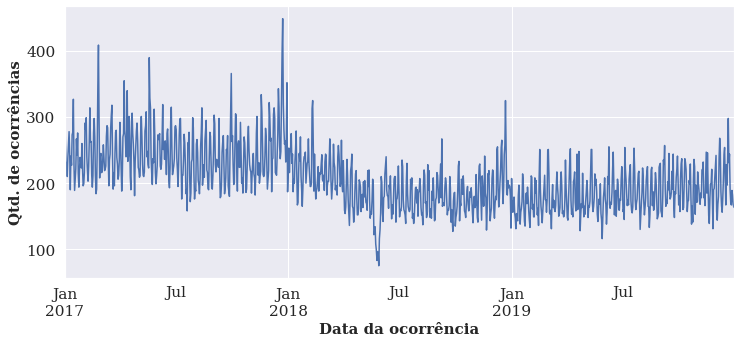

In [18]:
datatran_st_plot = datatran_st.plot(figsize=(12,5))

datatran_st_plot.set_xlabel('Data da ocorrência',
                            fontsize=15,
                            weight='bold')

datatran_st_plot.set_ylabel('Qtd. de ocorrências',
                            fontsize=15,
                            weight='bold')

datatran_st_plot.legend().remove()

figure = datatran_st_plot.get_figure()
figure.show()

## 4) Decompondo a série temporal

In [19]:
decomposicao_st = seasonal_decompose(datatran_st,
                                     period = 30)

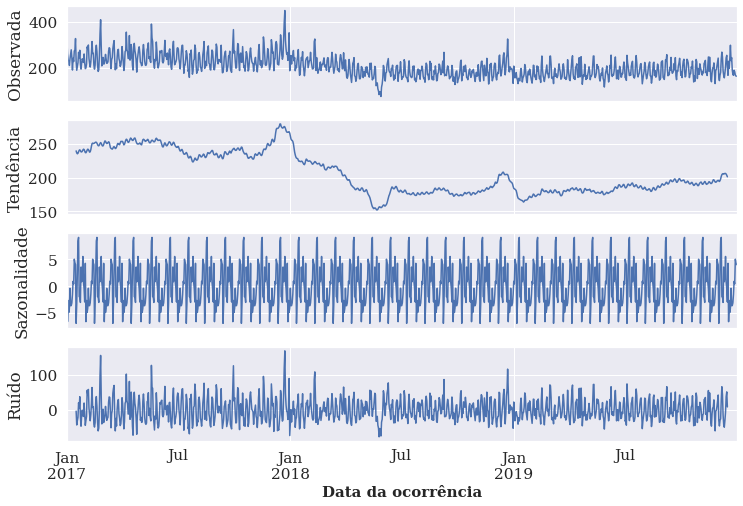

In [20]:
fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize=(12,8))

decomposicao_st.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observada')

decomposicao_st.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Tendência')

decomposicao_st.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Sazonalidade')

decomposicao_st.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Ruído')

axes[3].set_xlabel('Data da ocorrência',
                    fontsize=15,
                    weight='bold')

fig.show()

## 5) Treinando o modelo ARIMA

### 5.1) Separando amostras de treino e de teste


* Antes de treinarmos o nosso modelo, precisamos separar as amostras de treino e teste.


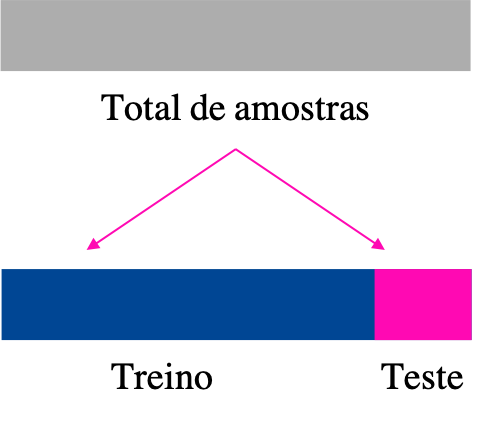

* Desta forma, para o treino o modelo terá acesso à "resposta correta" para ajustar seus parâmetros.


* A partir daí, o modelo fará previsões que serão comparadas às amostras de teste.


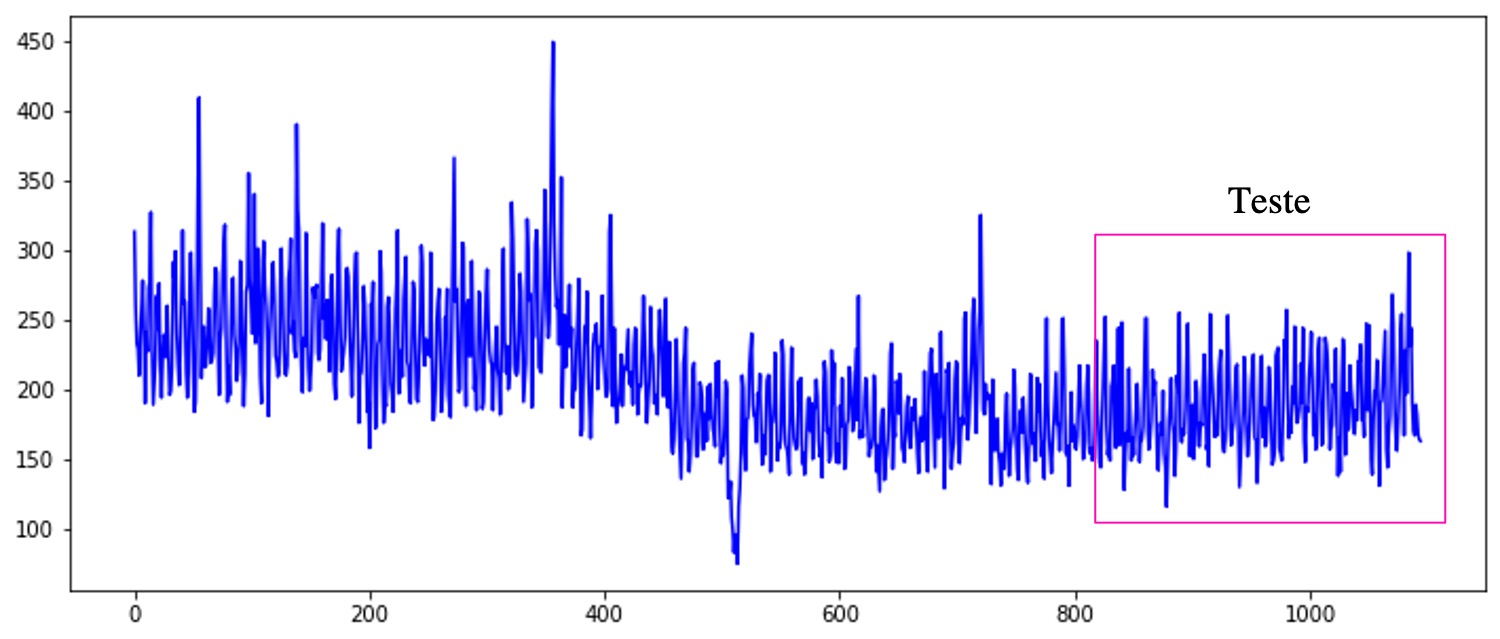

In [21]:
X = datatran_st.values

In [22]:
len(X)

1095

---
* Por questões de tempo, iremos separar 90% das amostras para treino e 10% para teste, porém outras proporções de separações de amostras são mais apropriadas.
---

In [23]:
tam = int(len(X) * 0.90)
treino, teste = X[0:tam], X[tam:len(X)]

In [24]:
print('treino = {}, teste = {}'.format(len(treino), len(teste)))

treino = 985, teste = 110


### 5.2) Encontrando os melhores valores para p, d, e q 


* p --> valor atual depende dos p valores anteriores;


* d --> grau da tendência (linear, quadrática etc.);


* q --> quantidade de observações passadas que a série de relaciona bem.

In [25]:
p = d = q = range(0,5)

In [26]:
print('p = {}\nd = {}\nq = {}'.format(p, d, q))

p = range(0, 5)
d = range(0, 5)
q = range(0, 5)


In [27]:
combinacoes_pdq = list(itertools.product(p,d,q))

In [28]:
combinacoes_pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [29]:
len(combinacoes_pdq)

125

In [30]:
%%time

menor_aic = -1
melhor_pdq = (0, 0, 0)

for pdq in combinacoes_pdq:
    try:
        model_arima = ARIMA(treino, order = pdq)
        model_arima_fit = model_arima.fit()
        
        print(pdq, model_arima_fit.aic)
        
        if menor_aic == -1:
            menor_aic = model_arima_fit.aic
            melhor_pdq = pdq
        elif model_arima_fit.aic < menor_aic:
            menor_aic = model_arima_fit.aic
            melhor_pdq = pdq
    except:
        continue

(0, 0, 0) 10408.390348871579
(0, 0, 1) 9896.21375397954
(0, 0, 2) 9732.617420502316
(0, 0, 3) 9702.570119060136
(0, 0, 4) 9696.480528013772
(0, 1, 0) 9866.765277953038
(0, 1, 1) 9868.734411719131
(0, 1, 2) 9587.177947745802
(0, 1, 3) 9538.721835019049
(0, 1, 4) 9539.034840190587
(0, 2, 0) 10542.342888938732
(0, 2, 1) 9866.62332637436
(0, 2, 2) 9868.605268497578
(0, 2, 3) 9592.50681739581
(0, 2, 4) 9544.292481973938
(1, 0, 0) 9725.818215089112
(1, 0, 1) 9702.632331666933
(1, 0, 2) 9598.551614657903
(1, 0, 3) 9550.775525741938
(1, 0, 4) 9550.816875301518
(1, 1, 0) 9868.74630451055
(1, 1, 3) 9540.35343422083
(1, 1, 4) 9518.52665946556
(1, 2, 0) 10366.030641680489
(2, 0, 0) 9700.744864407283
(2, 0, 1) 9630.599141681265
(2, 0, 2) 9574.466784842043
(2, 0, 3) 9552.360598689414
(2, 0, 4) 9528.516650151876
(2, 1, 0) 9834.477464349853
(2, 1, 2) 9410.70915796779
(2, 1, 3) 9155.057535851472
(2, 1, 4) 9124.08906814294
(2, 2, 0) 10312.554946104141
(3, 0, 0) 9702.055854129074
(3, 0, 1) 9515.509763198

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 2) 9329.221630558972
(3, 0, 3) 9158.30342089741
(3, 0, 4) 9131.695145633461
(3, 1, 0) 9722.799457756584
(3, 1, 1) 9429.630892334078
(3, 1, 2) 9326.123280290889


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 1, 3) 9125.934024950317


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(3, 1, 4) 9129.619402402453
(3, 2, 0) 10249.456163865585


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 2, 3) 9331.91029356141
(4, 0, 0) 9653.502975402196
(4, 0, 1) 9437.644417592055


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 3) 9134.54561171885


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(4, 0, 4) 9137.857981149666
(4, 1, 0) 9572.0265950094
(4, 1, 1) 9380.682060730665
(4, 1, 2) 9222.437516359925
(4, 1, 3) 9127.065367974923
(4, 1, 4) 9127.652023918545
(4, 2, 0) 10153.174150982048
(4, 2, 2) 9384.134350617363
(4, 2, 3) 9230.223493842637
CPU times: user 2min 3s, sys: 1.44 s, total: 2min 4s
Wall time: 1min 49s


In [31]:
print('menor_aic = {}, melhor_pdq = {}'.format(menor_aic, melhor_pdq))

menor_aic = 9124.08906814294, melhor_pdq = (2, 1, 4)


### 5.3) Treinando o modelo

In [32]:
lista_historico = list(treino)
lista_previsoes = list()

In [33]:
%%time

for indice in range(len(teste)):
    modelo = ARIMA(lista_historico, order = melhor_pdq)
    modelo_fit = modelo.fit(disp = 0)
    previsao = modelo_fit.forecast()[0]
    lista_previsoes.append(previsao)
    lista_historico.append(teste[indice])
    
    print('previsto = {}, esperado = {}'.format(previsao, teste[indice]))

previsto = [206.52744485], esperado = [202]
previsto = [225.01393581], esperado = [190]
previsto = [203.91881561], esperado = [245]
previsto = [200.9077495], esperado = [189]
previsto = [162.38764427], esperado = [176]
previsto = [164.88465746], esperado = [179]
previsto = [186.36784864], esperado = [186]
previsto = [211.72468235], esperado = [218]
previsto = [231.0591116], esperado = [191]
previsto = [206.49135558], esperado = [244]
previsto = [203.5691171], esperado = [164]
previsto = [156.09388513], esperado = [148]
previsto = [155.46730683], esperado = [187]
previsto = [187.94985387], esperado = [184]
previsto = [207.91197421], esperado = [209]
previsto = [225.23307104], esperado = [221]
previsto = [215.61347146], esperado = [241]
previsto = [200.47658064], esperado = [201]
previsto = [170.77495068], esperado = [167]
previsto = [164.39286451], esperado = [181]
previsto = [189.86425492], esperado = [157]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


previsto = [201.68994413], esperado = [207]
previsto = [227.06831348], esperado = [229]
previsto = [219.61029605], esperado = [237]
previsto = [200.07602901], esperado = [190]
previsto = [167.40892518], esperado = [160]
previsto = [160.97153611], esperado = [163]
previsto = [181.68388016], esperado = [197]
previsto = [215.61210786], esperado = [237]
previsto = [237.49604703], esperado = [232]
previsto = [223.22676502], esperado = [221]
previsto = [197.0975158], esperado = [190]
previsto = [169.82763892], esperado = [157]
previsto = [161.61363041], esperado = [172]
previsto = [187.37569662], esperado = [174]
previsto = [208.53181282], esperado = [204]
previsto = [225.83356137], esperado = [199]
previsto = [208.49530934], esperado = [229]
previsto = [195.69819774], esperado = [178]
previsto = [159.88191899], esperado = [138]
previsto = [150.14007364], esperado = [165]
previsto = [179.33490109], esperado = [141]
previsto = [189.98071801], esperado = [202]
previsto = [218.79784695], espera

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


previsto = [157.08793149], esperado = [185]
previsto = [183.70254206], esperado = [178]
previsto = [203.2776184], esperado = [220]


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


previsto = [226.4478176], esperado = [220]
previsto = [212.82530282], esperado = [232]
previsto = [195.90853302], esperado = [178]
previsto = [161.22901112], esperado = [182]
previsto = [168.17221341], esperado = [166]
previsto = [181.59132833], esperado = [209]
previsto = [219.61520313], esperado = [247]
previsto = [239.93696768], esperado = [185]
previsto = [205.35999859], esperado = [246]
previsto = [206.21728222], esperado = [195]
previsto = [170.92962532], esperado = [151]
previsto = [161.57726546], esperado = [139]
previsto = [175.58410236], esperado = [177]
previsto = [207.87166714], esperado = [199]
previsto = [219.635935], esperado = [200]
previsto = [205.84439329], esperado = [221]
previsto = [189.84771397], esperado = [176]
previsto = [157.90681252], esperado = [131]
previsto = [146.36385821], esperado = [190]
previsto = [186.70872002], esperado = [192]


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


previsto = [207.35244152], esperado = [209]
previsto = [221.64684609], esperado = [224]
previsto = [213.60488502], esperado = [242]
previsto = [198.21970062], esperado = [157]
previsto = [153.92481331], esperado = [144]
previsto = [154.87093049], esperado = [168]
previsto = [181.19199788], esperado = [180]
previsto = [205.39475762], esperado = [238]
previsto = [232.0679931], esperado = [268]
previsto = [229.30280857], esperado = [247]
previsto = [202.16583993], esperado = [187]
previsto = [169.19718809], esperado = [166]
previsto = [168.44624267], esperado = [156]
previsto = [185.12639751], esperado = [177]
previsto = [212.92502608], esperado = [204]
previsto = [225.9348127], esperado = [243]
previsto = [223.99349133], esperado = [254]
previsto = [204.33879045], esperado = [206]
previsto = [174.33026738], esperado = [167]
previsto = [168.02340146], esperado = [228]
previsto = [212.69243235], esperado = [197]
previsto = [223.6358163], esperado = [239]
previsto = [247.31636492], esperado

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


previsto = [253.43277935], esperado = [231]


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


previsto = [207.30460286], esperado = [244]
previsto = [200.8305151], esperado = [190]
previsto = [187.0491324], esperado = [171]
previsto = [203.93642962], esperado = [167]
previsto = [222.51016686], esperado = [189]
previsto = [233.15630078], esperado = [182]
previsto = [211.66029596], esperado = [168]
previsto = [178.71706624], esperado = [164]
previsto = [156.87542193], esperado = [163]
CPU times: user 10min 32s, sys: 4.13 s, total: 10min 37s
Wall time: 9min 22s


### 5.4) Avaliando o modelo

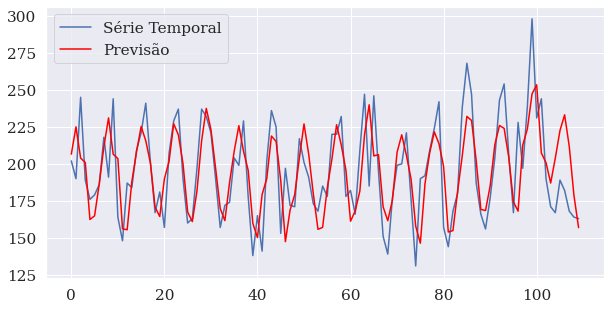

In [34]:
plt.figure(figsize=(10,5))
plt.plot(teste, label="Série Temporal")
plt.plot(lista_previsoes, color='red', label="Previsão")
plt.legend()
plt.show()

In [35]:
print('teste = {}, previsão = {}'.format(len(teste), len(lista_previsoes)))

teste = 110, previsão = 110


---
* Para avaliar o modelo, iremos utilizar o Erro Quadrático Médio (Mean Squared Error ou MSE).


$MSE = \frac{1}{n}\sum_{i = 1}^{n}(teste_{i} - previsao_{i})^2$


* Exemplo 1: resultado com estimativas semelhantes.


$n = 3$


$teste = \left [100, 102, 104\right ]$


$previsao = \left [102, 104, 106\right ]$


$MSE = \frac{(100 - 102)^2 + (102 - 104)^2 + (104 - 106)^2}{3} = \frac{4 + 4 + 4}{3} = 4$


* Exemplo 2: resultado com estimativas pouco semelhantes.


$n = 3$


$teste = \left [100, 102, 104\right ]$


$previsao = \left [200, 202, 204\right ]$


$MSE = \frac{(100 - 200)^2 + (102 - 202)^2 + (104 - 204)^2}{3} = \frac{10000 + 10000 + 10000}{3} = 10000$


* Quanto mais próximo de 0 o MSE estiver, melhor.
---

In [36]:
error = mean_squared_error(teste, lista_previsoes)
print('Test MSE: %.4f' % error)

Test MSE: 532.5757


### Quais seriam outras análises que poderíamos fazer com estes dados?

## 6) Trabalhando com dados de 2020

In [37]:
datatran_2020_df = pd.read_csv('../input/brazil-highway-traffic-accidents/por_ocorrencias/datatran2020.csv', 
                               sep = ';',
                               encoding = 'latin-1')

In [38]:
datatran_2020_df.head()

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,260031.0,2020-01-01,quarta-feira,01:00:00,TO,153.0,"678,1",GURUPI,Animais na Pista,Atropelamento de Animal,...,5,0,0,5,1,"-11,77460203","-49,10744996",SR-TO,UOP01/TO,NaN
1,260036.0,2020-01-01,quarta-feira,01:00:00,RJ,116.0,178,NOVA IGUACU,Falta de Atenção do Pedestre,Atropelamento de Pedestre,...,0,1,0,0,1,"-22,75223028","-43,4379103",SR-RJ,DEL5/1,UOP02/RJ
2,260037.0,2020-01-01,quarta-feira,01:52:00,SC,101.0,"206,9",SAO JOSE,Ingestão de Álcool,Colisão lateral,...,0,1,0,1,2,"-27,59193546","-48,61824557",SR-SC,DEL8/1,UOP01/SC
3,260038.0,2020-01-01,quarta-feira,01:15:00,RO,364.0,236,CACOAL,Velocidade Incompatível,Saída de leito carroçável,...,1,0,0,1,1,"-11,44624577","-61,43761218",SR-RO,DEL21/2,UOP02/RO
4,260039.0,2020-01-01,quarta-feira,01:30:00,PR,153.0,360,REBOUCAS,Ingestão de Álcool,Capotamento,...,4,0,0,6,1,"-25,67503796","-50,75089805",SR-PR,DEL7/3,UOP04/PR


In [39]:
datatran_new_df = pd.concat([datatran_2017_df, datatran_2018_df, datatran_2019_df, datatran_2020_df])

In [40]:
datatran_new_df.head()

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,8.0,2017-01-01,domingo,00:00:00,PR,376.0,112,PARANAVAI,Fenômenos da Natureza,Queda de ocupante de veículo,...,1,0,0,1,1,"-23,09880731","-52,38789369",SR-PR,DEL7/7,UOP05/PR
1,9.0,2017-01-01,domingo,00:01:00,SC,101.0,234,PALHOCA,Falta de Atenção à Condução,Colisão com objeto estático,...,0,1,0,0,1,"-27,8101","-48,6357",SR-SC,DEL8/1,UOP02/SC
2,11.0,2017-01-01,domingo,00:00:00,PR,153.0,"56,9",SANTO ANTONIO DA PLATINA,Animais na Pista,Capotamento,...,0,0,0,2,1,"-23,36951985","309,93513107",SR-PR,DEL7/7,UOP07/PR
3,12.0,2017-01-01,domingo,00:00:00,GO,153.0,435,ANAPOLIS,Avarias e/ou desgaste excessivo no pneu,Tombamento,...,1,0,0,1,1,"-16,27473677","-48,96908998",SR-GO,DEL1/2,UOP01/GO
4,13.0,2017-01-01,domingo,00:00:00,SC,280.0,"77,3",CORUPA,Ingestão de Álcool,Saída de leito carroçável,...,0,0,0,1,1,"-26,44675249","-49,20166969",SR-SC,DEL8/6,UOP03/SC


In [41]:
datatran_new_df.dtypes

id                        float64
data_inversa               object
dia_semana                 object
horario                    object
uf                         object
br                        float64
km                         object
municipio                  object
causa_acidente             object
tipo_acidente              object
classificacao_acidente     object
fase_dia                   object
sentido_via                object
condicao_metereologica     object
tipo_pista                 object
tracado_via                object
uso_solo                   object
pessoas                     int64
mortos                      int64
feridos_leves               int64
feridos_graves              int64
ilesos                      int64
ignorados                   int64
feridos                     int64
veiculos                    int64
latitude                   object
longitude                  object
regional                   object
delegacia                  object
uop           

In [42]:
datatran_new_df['data_inversa'] = pd.to_datetime(datatran_new_df['data_inversa'], 
                                                 yearfirst = True,
                                                 format = '%Y-%m-%d')

In [43]:
datatran_new_df.sort_values(by = 'data_inversa', inplace = True)

In [44]:
datatran_new_df

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,8.0,2017-01-01,domingo,00:00:00,PR,376.0,112,PARANAVAI,Fenômenos da Natureza,Queda de ocupante de veículo,...,1,0,0,1,1,"-23,09880731","-52,38789369",SR-PR,DEL7/7,UOP05/PR
213,272.0,2017-01-01,domingo,19:20:00,PE,232.0,"408,9",SERRA TALHADA,Desobediência às normas de trânsito pelo condutor,Colisão transversal,...,2,0,0,2,2,"-8,0578381","-34,8828969",SR-PE,DEL11/4,UOP01/PE
212,271.0,2017-01-01,domingo,18:40:00,SC,116.0,"8,3",MAFRA,Não guardar distância de segurança,Colisão traseira,...,0,2,0,1,2,"-27,5953778","-48,5480499",SR-SC,DEL8/6,UOP01/SC
211,270.0,2017-01-01,domingo,20:00:00,PR,467.0,"75,3",TOLEDO,Falta de Atenção à Condução,Saída de leito carroçável,...,0,0,0,1,1,"-24,75166889","-53,69530052",SR-PR,DEL7/4,UOP06/PR
210,269.0,2017-01-01,domingo,19:15:00,TO,153.0,"146,9",ARAGUAINA,Velocidade Incompatível,Colisão traseira,...,4,0,0,4,2,"-7,22108702","-48,2476294",SR-TO,UOP04/TO,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45249,311328.0,2020-09-30,quarta-feira,22:45:00,MG,381.0,442,SABARA,Defeito Mecânico no Veículo,Incêndio,...,0,1,0,0,1,"-19,8183901","-43,81131985",SR-MG,UOP01,DEL01
45250,311329.0,2020-09-30,quarta-feira,21:10:00,ES,259.0,95,BAIXO GUANDU,Falta de Atenção à Condução,Colisão com objeto estático,...,2,0,0,2,1,"-19,50436831","-40,95222092",SR-ES,UOP01,DEL02
45251,311330.0,2020-09-30,quarta-feira,18:10:00,MG,116.0,"175,2",PADRE PARAISO,Ultrapassagem Indevida,Colisão frontal,...,0,1,0,0,2,"-17,05568579","-41,46147724",SR-MG,UOP02,DEL11
45253,311332.0,2020-09-30,quarta-feira,22:00:00,PR,476.0,150,ARAUCARIA,Ingestão de Álcool,Colisão com objeto estático,...,0,0,0,1,1,"-25,558477","-49,368313",SR-PR,UOP03,DEL01


In [45]:
datatran_new_df.dtypes

id                               float64
data_inversa              datetime64[ns]
dia_semana                        object
horario                           object
uf                                object
br                               float64
km                                object
municipio                         object
causa_acidente                    object
tipo_acidente                     object
classificacao_acidente            object
fase_dia                          object
sentido_via                       object
condicao_metereologica            object
tipo_pista                        object
tracado_via                       object
uso_solo                          object
pessoas                            int64
mortos                             int64
feridos_leves                      int64
feridos_graves                     int64
ilesos                             int64
ignorados                          int64
feridos                            int64
veiculos        

In [46]:
datatran_new_st = datatran_new_df['data_inversa'].groupby(datatran_new_df['data_inversa'].dt.to_period('D')).agg('count').to_frame()

In [47]:
datatran_new_st.columns = ['acidentes']

In [48]:
datatran_new_st

,acidentes
data_inversa,
2017-01-01,313
2017-01-02,260
2017-01-03,233
2017-01-04,229
2017-01-05,210
...,...
2020-09-26,209
2020-09-27,237
2020-09-28,169


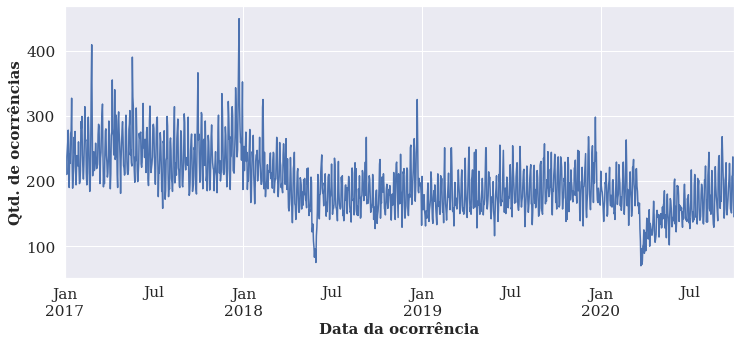

In [49]:
datatran_new_st_plot = datatran_new_st.plot(figsize=(12,5))

datatran_new_st_plot.set_xlabel('Data da ocorrência',
                                fontsize=15,
                                weight='bold')

datatran_new_st_plot.set_ylabel('Qtd. de ocorrências',
                                fontsize=15,
                                weight='bold')

datatran_new_st_plot.legend().remove()

figure = datatran_new_st_plot.get_figure()
figure.show()

In [52]:
decomposicao_new_st = seasonal_decompose(datatran_new_st,
                                         period = 30)

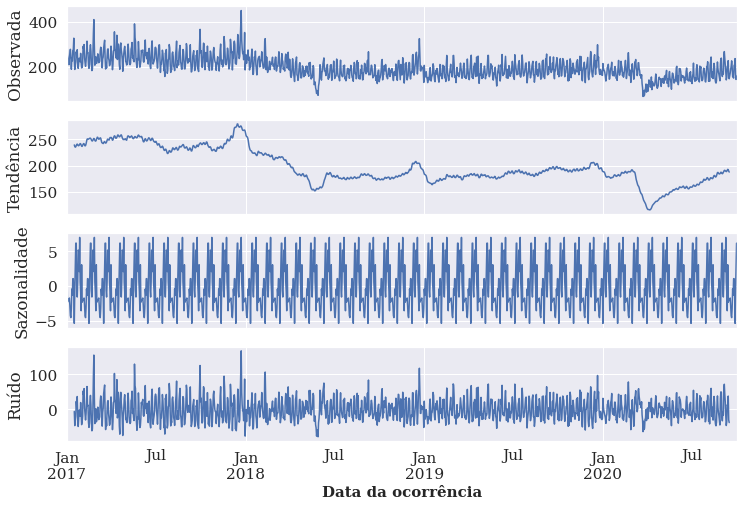

In [53]:
fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize=(12,8))

decomposicao_new_st.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observada')

decomposicao_new_st.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Tendência')

decomposicao_new_st.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Sazonalidade')

decomposicao_new_st.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Ruído')

axes[3].set_xlabel('Data da ocorrência',
                    fontsize=15,
                    weight='bold')

fig.show()

In [54]:
X = datatran_new_st.values
tam = int(len(X) * 0.90)
treino, teste = X[0:tam], X[tam:len(X)]

print('treino = {}, teste = {}'.format(len(treino), len(teste)))

treino = 1232, teste = 137


In [55]:
%%time

p = d = q = range(0,5)
combinacoes_pdq = list(itertools.product(p,d,q))

menor_aic = -1
melhor_pdq = (0, 0, 0)

for pdq in combinacoes_pdq:
    try:
        model_arima = ARIMA(treino, order = pdq)
        model_arima_fit = model_arima.fit()
        
        print(pdq, model_arima_fit.aic)
        
        if menor_aic == -1:
            menor_aic = model_arima_fit.aic
            melhor_pdq = pdq
        elif model_arima_fit.aic < menor_aic:
            menor_aic = model_arima_fit.aic
            melhor_pdq = pdq
    except:
        continue

(0, 0, 0) 13026.886163332736
(0, 0, 1) 12359.859112689612
(0, 0, 2) 12144.213670539153
(0, 0, 3) 12088.7652101521
(0, 0, 4) 12072.470579672641
(0, 1, 0) 12261.575665728677
(0, 1, 1) 12262.750143647656
(0, 1, 2) 11931.577968968078
(0, 1, 3) 11873.901621621064
(0, 1, 4) 11875.681993007678
(0, 2, 0) 13128.822380376374
(0, 2, 1) 12261.717508862386
(0, 2, 2) 12262.959065415964
(0, 2, 3) 11936.884933532489
(0, 2, 4) 11879.61335027416
(1, 0, 0) 12096.57043116719
(1, 0, 1) 12077.180394400106
(1, 0, 2) 11943.910436797061
(1, 0, 3) 11887.43643755462
(1, 0, 4) 11889.0672384257
(1, 1, 0) 12263.06287895323
(1, 1, 3) 11875.855493185518
(1, 1, 4) 11854.61945855306
(1, 2, 0) 12888.83625253267


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 2, 3) 11905.289758257677
(2, 0, 0) 12076.763579238954
(2, 0, 1) 11974.335660629922
(2, 0, 2) 11913.12994073395
(2, 0, 3) 11889.362861761538
(2, 0, 4) 11863.601748315396
(2, 1, 0) 12224.798167360781
(2, 1, 2) 11717.851901836559
(2, 1, 3) 11397.771460136315
(2, 1, 4) 11365.240750401605
(2, 2, 0) 12817.726142062864


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 2, 2) 11845.086699355237
(3, 0, 0) 12077.296112426287
(3, 0, 1) 11851.806254341644
(3, 0, 2) 11618.828303555212
(3, 0, 3) 11399.683743979267
(3, 0, 4) 11372.315211028028
(3, 1, 0) 12097.539178779605
(3, 1, 1) 11745.698420675999
(3, 1, 2) 11593.027119086697
(3, 1, 3) 11367.142566349652


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 1, 4) 11372.599401948715
(3, 2, 0) 12750.034419964664
(3, 2, 2) 11750.010599748497


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 2, 3) 11603.358299368285
(4, 0, 0) 12018.11316642873
(4, 0, 1) 11753.479094360899


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


(4, 0, 3) 11375.178239234257


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: Converge

(4, 0, 4) 11380.772132657912
(4, 1, 0) 11898.435281757265
(4, 1, 1) 11673.334348458335
(4, 1, 2) 11472.622635571437
(4, 1, 3) 11368.276423232915
(4, 1, 4) 11366.703961292962
(4, 2, 0) 12625.960087948984
(4, 2, 2) 11677.039443469253
(4, 2, 3) 11481.23424195378
CPU times: user 3min 45s, sys: 645 ms, total: 3min 46s
Wall time: 3min 29s


In [56]:
print('menor_aic = {}, melhor_pdq = {}'.format(menor_aic, melhor_pdq))

menor_aic = 11365.240750401605, melhor_pdq = (2, 1, 4)


In [57]:
%%time

lista_historico = list(treino)
lista_previsoes = list()

for indice in range(len(teste)):
    modelo = ARIMA(lista_historico, order = melhor_pdq)
    modelo_fit = modelo.fit(disp = 0)
    previsao = modelo_fit.forecast()[0]
    lista_previsoes.append(previsao)
    lista_historico.append(teste[indice])
    
    print('previsto = {}, esperado = {}'.format(previsao, teste[indice]))

previsto = [168.02424678], esperado = [151]
previsto = [142.16319127], esperado = [142]
previsto = [127.79197106], esperado = [128]
previsto = [123.51594823], esperado = [102]
previsto = [126.60426661], esperado = [150]
previsto = [159.69824536], esperado = [173]
previsto = [172.63894384], esperado = [170]
previsto = [164.03298339], esperado = [158]
previsto = [143.99702017], esperado = [130]
previsto = [121.98505982], esperado = [130]
previsto = [124.38670413], esperado = [144]
previsto = [143.66066888], esperado = [139]
previsto = [157.11201687], esperado = [162]
previsto = [171.01152912], esperado = [198]
previsto = [175.65613304], esperado = [203]
previsto = [163.45845469], esperado = [134]
previsto = [128.42508525], esperado = [161]
previsto = [143.83206867], esperado = [122]


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


previsto = [142.03399897], esperado = [140]
previsto = [165.17064951], esperado = [193]
previsto = [188.57924342], esperado = [191]
previsto = [178.57055818], esperado = [192]
previsto = [164.50491616], esperado = [178]
previsto = [149.38464625], esperado = [138]
previsto = [138.49718559], esperado = [163]
previsto = [164.08288645], esperado = [157]
previsto = [177.00873566], esperado = [161]
previsto = [183.67217668], esperado = [155]
previsto = [169.80111752], esperado = [159]
previsto = [152.67941554], esperado = [140]
previsto = [132.22359211], esperado = [129]
previsto = [129.81991438], esperado = [153]


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


previsto = [152.73049696], esperado = [142]
previsto = [163.16654733], esperado = [181]
previsto = [183.44083313], esperado = [195]
previsto = [179.15366311], esperado = [174]
previsto = [156.58827432], esperado = [144]
previsto = [135.35770716], esperado = [140]
previsto = [136.75702964], esperado = [142]
previsto = [151.41539474], esperado = [138]
previsto = [164.37260729], esperado = [173]
previsto = [181.27554685], esperado = [170]
previsto = [169.18467491], esperado = [179]
previsto = [157.00559963], esperado = [136]
previsto = [129.69111154], esperado = [143]
previsto = [136.22078438], esperado = [127]
previsto = [143.39664704], esperado = [158]
previsto = [170.38053126], esperado = [170]
previsto = [178.11480608], esperado = [217]
previsto = [187.51833121], esperado = [158]
previsto = [149.53558114], esperado = [145]
previsto = [136.14748716], esperado = [137]
previsto = [135.26206218], esperado = [153]
previsto = [156.42942342], esperado = [140]
previsto = [166.06142899], esper

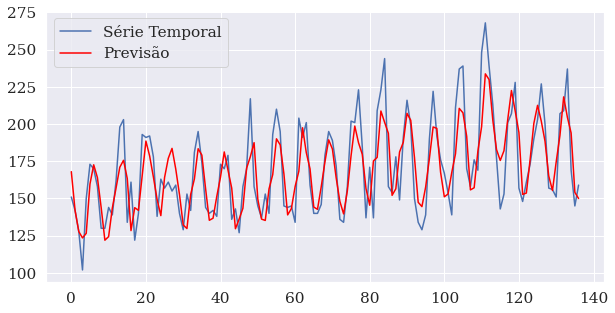

In [58]:
plt.figure(figsize=(10,5))
plt.plot(teste, label="Série Temporal")
plt.plot(lista_previsoes, color='red', label="Previsão")
plt.legend()
plt.show()

In [59]:
print('teste = {}, previsão = {}'.format(len(teste), len(lista_previsoes)))

teste = 137, previsão = 137


In [60]:
error = mean_squared_error(teste, lista_previsoes)
print('Test MSE: %.3f' % error)

Test MSE: 355.143
